In [1]:
import sys
import warnings
import tensorflow as tf
tf.compat.v1.reset_default_graph()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(10086)


c:\Users\Xunjing\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
df = pd.read_csv('.\GOOG-year.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016/11/2,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016/11/3,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016/11/4,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016/11/7,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016/11/8,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))   #取收盘价为feature，并取log加以处理
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) 
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


In [ ]:
test_size = 30
simulation_size = 10         #模拟总次数

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
#执行多头注意力机制的各个步骤，包括全连接变换、注意力权重计算、掩码处理、softmax归一化、加权求和和层归一化
#注意力机制可以帮助模型在处理序列数据时关注不同位置的信息，并提高模型的性能和泛化能力
def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    #参数初始化
    T_q = tf.shape(queries)[1] 
    T_k = tf.shape(keys)[1]  
    Q = tf.layers.dense(queries, num_units, name='Q')  
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
    K, V = tf.split(K_V, 2, -1) 
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)  
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)  
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0) 
    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                
    # 计算注意力权重
    align = align / tf.sqrt(tf.cast(tf.shape(K_)[-1], tf.float32))  
    # 归一化注意力权重

    paddings = tf.fill(tf.shape(align), float('-inf'))  
    # 创建填充值张量


    key_masks = tf.tile(k_masks, [num_heads, 1])  
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1]) 
    align = tf.where(tf.equal(key_masks, 0), paddings, align)  
    # 对注意力权重进行掩码处理

    if future_binding:
        # 创建下三角矩阵,复制下三角矩阵以适应注意力权重,对注意力权重进行掩码处理
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(tf.ones([T_q, T_k])).to_dense() 
        masks = tf.tile(tf.expand_dims(lower_tri, 0), [tf.shape(align)[0], 1, 1])  
        
        align = tf.where(tf.equal(masks, 0), paddings, align)  
        # 
    align = tf.nn.softmax(align)  
    query_masks = tf.cast(q_masks, tf.float32) 
    # 获取查询的掩码
    query_masks = tf.tile(query_masks, [num_heads, 1])  
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])  
    # 复制查询的掩码以适应值张量的时间步数
    align *= query_masks  
    # 对注意力权重进行查询的掩码处理

    outputs = tf.matmul(align, V_)  
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2) 
    outputs = layer_norm(outputs+queries)  
    return outputs 

def pointwise_feedforward(inputs, hidden_units, activation=None):
    # 第一个全连接层和第二个全连接层的参数
    dense1_params = {'units': 4*hidden_units, 'activation': activation}
    dense2_params = {'units': hidden_units, 'activation': None}
    # 第一个全连接层
    outputs = tf.layers.dense(inputs, **dense1_params)
    # 第二个全连接层
    outputs = tf.layers.dense(outputs, **dense2_params)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs

def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    # 生成位置编码
    positions = tf.range(T)
    positions = tf.expand_dims(positions, 0)
    positions = tf.tile(positions, [tf.shape(inputs)[0], 1])
    outputs = embed_seq(positions, T, embed_dim, zero_pad=False, scale=False)
    
    # 掩码处理
    outputs = tf.expand_dims(tf.to_float(mask), -1) * outputs
    
    return outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    
    # 生成位置编码
    positions = tf.reshape(tf.range(tf.cast(T, tf.float32)), [-1, 1])
    i = tf.range(0, repr_dim, 2, dtype=tf.float32)
    denom = tf.pow(10000.0, i / repr_dim)
    enc = tf.concat([tf.sin(positions / denom), tf.cos(positions / denom)], axis=1)
    enc = tf.expand_dims(enc, axis=0)
    
    # 掩码处理
    outputs = tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.cast(mask, tf.float32), axis=-1)
    
    return outputs

def label_smoothing(inputs, epsilon=0.1):  
    #标签平滑化通过将输入与一个较小的常数epsilon除以类别数C相加，以减少模型对训练数据的过拟合。
    #函数返回平滑化后的结果。标签平滑化可以帮助提高模型的泛化能力和鲁棒性。
    # 获取输入张量的最后一个维度的大小
    C = inputs.get_shape().as_list()[-1]
    # 对输入进行标签平滑化处理
    smoothed_inputs = ((1 - epsilon) * inputs) + (epsilon / C)
    return smoothed_inputs

def layer_norm(inputs, epsilon=1e-8):
    # 计算输入张量的均值和方差
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    # 获取输入张量的形状
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return  gamma * normalized + beta



class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks=2,
                 num_heads=8,
                 min_freq=50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        # 对输入进行全连接层处理，并进行dropout
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob=0.8)
        
        # 计算输入的平均值，并生成mask用于self-attention
        x_mean = tf.reduce_mean(self.X, axis=2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        # 多个attention模块的堆叠
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d' % i, reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries=encoder_embedded,
                                                  keys=encoder_embedded,
                                                  q_masks=en_masks,
                                                  k_masks=en_masks,
                                                  future_binding=False,
                                                  num_units=size_layer,
                                                  num_heads=num_heads)

            with tf.variable_scope('encoder_feedforward_%d' % i, reuse=tf.AUTO_REUSE):
                # pointwise feedforward层
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                         embedded_size,
                                                         activation=tf.nn.relu)
                
        # 输出层，对最终结果进行全连接
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        
        # 损失函数，计算预测值与真实值的均方误差
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        
        # 优化器，使用Adam优化器进行模型参数的更新
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
def calculate_accuracy(real, predict):
    # 将真实值和预测值转换为NumPy数组，并加1平滑
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    error = np.abs(real - predict) / real
    percentage = 100 - np.sqrt(np.mean(np.square(error))) * 100
    
    return percentage

def anchor(signal, weight):
    buffer = []
    # 平滑处理信号
    for i in signal:
        smoothed_val = buffer[-1] * weight + (1 - weight) * i if buffer else i
        buffer.append(smoothed_val)
    
    return buffer
def reset_and_initialize_session():
    # 重置TensorFlow默认图
    tf.reset_default_graph()
    # 创建Attention模型实例
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    # 创建并初始化TensorFlow交互式会话
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    return modelnn, sess

def train_model(modelnn, sess, df_train):
    pbar = tqdm(range(epoch), desc='train loop')
    for _ in pbar:
        total_loss, total_acc = [], []
        # 分批次训练模型
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            # 获取当前批次的输入和标签
            batch_x = np.expand_dims(df_train.iloc[k: index, :].values, axis=0)
            batch_y = df_train.iloc[k + 1: index + 1, :].values
            # 运行模型的logits、optimizer和cost节点
            logits, _, loss = sess.run([modelnn.logits, modelnn.optimizer, modelnn.cost],
                                       feed_dict={modelnn.X: batch_x, modelnn.Y: batch_y})
            # 记录损失和准确度
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        # 更新进度条
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

def predict_future(modelnn, sess, df_train, date_ori):
    # 预测未来数据
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    # 循环预测每个时间段
    for k in range(0, upper_b, timestamp):
        out_logits = sess.run(modelnn.logits,
                              feed_dict={modelnn.X: np.expand_dims(df_train.iloc[k: k + timestamp], axis=0)})
        output_predict[k + 1: k + timestamp + 1] = out_logits

    # 处理剩余未预测的时间段
    if upper_b != df_train.shape[0]:
        out_logits = sess.run(modelnn.logits,
                              feed_dict={modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis=0)})
        output_predict[upper_b + 1: df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days=1))

    # 继续预测未来多天
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(modelnn.logits,
                              feed_dict={modelnn.X: np.expand_dims(o, axis=0)})
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    return output_predict

def inverse_transform_and_process(output_predict):
    # 对预测结果进行逆归一化和处理
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    return deep_future

def forecast():
    modelnn, sess = reset_and_initialize_session()
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
    train_model(modelnn, sess, df_train)
    output_predict = predict_future(modelnn, sess, df_train, date_ori)
    # 对预测结果进行逆归一化和处理
    deep_future = inverse_transform_and_process(output_predict)
    return deep_future[-test_size:]

In [ ]:
num_layers = 1   #注意力层数
size_layer = 128   #模型中每个注意力层的单元数或隐藏单元的数量
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001
timestamp = 5
epoch = 300


In [ ]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
tf.reset_default_graph()
results = []
for i in range(simulation_size):
    print('simulation times%d'%(i + 1))
    results.append(forecast())


simulation times1

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:119: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:53: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(inputs, **dens

train loop: 100%|██████████| 300/300 [00:36<00:00,  8.12it/s, acc=97.6, cost=0.00148] 
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:119: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Q = tf.layers.dense(queries, num_units, name='Q')
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:8: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:53: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version.

simulation times2


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:36<00:00,  8.14it/s, acc=96.6, cost=0.00338] 
C:\Users\admin\AppData\Local\

simulation times3


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  8.04it/s, acc=97.4, cost=0.00231] 
C:\Users\admin\AppData\Local\

simulation times4


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  8.04it/s, acc=97.6, cost=0.00187]
C:\Users\admin\AppData\Local\T

simulation times5


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  8.02it/s, acc=95.7, cost=0.00612] 
C:\Users\admin\AppData\Local\

simulation times6


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  8.07it/s, acc=98.2, cost=0.000797]
C:\Users\admin\AppData\Local\

simulation times7


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  7.96it/s, acc=97.9, cost=0.00143] 
C:\Users\admin\AppData\Local\

simulation times8


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  7.97it/s, acc=97.8, cost=0.00152] 
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:119: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.layers.dense(self.X, embedded_size)
C:\Users\admin\AppData

simulation times9


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
train loop: 100%|██████████| 300/300 [00:37<00:00,  8.03it/s, acc=98.1, cost=0.000954]
C:\Users\admin\AppData\Local\

simulation times10


C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:53: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(inputs, **dense1_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  outputs = tf.layers.dense(outputs, **dense2_params)
C:\Users\admin\AppData\Local\Temp/ipykernel_31056/3452388970.py:145: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
C:\Users\admin\anaconda3\lib\site-packages\tensorflow\python\client\session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSes

<Figure size 1080x216 with 0 Axes>

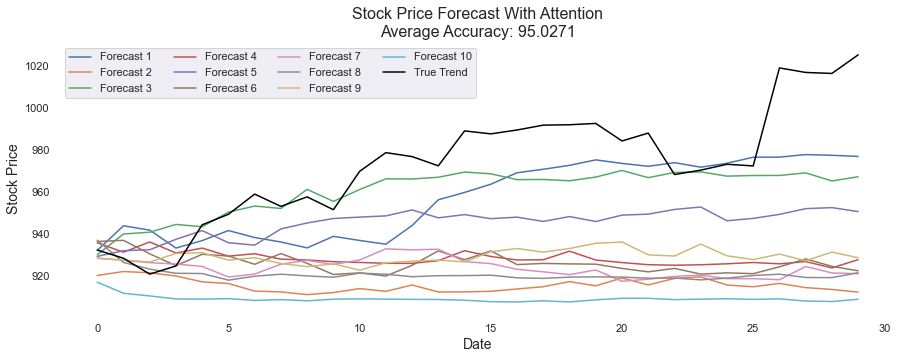

<Figure size 1080x216 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]
average_accuracy = np.mean(accuracies)

plt.figure(figsize=(15, 3))
plt.gca().set_facecolor('white')  # 设置整个图表的背景为白色

# 绘制预测曲线
for no, r in enumerate(results):
    plt.plot(r, label=f'Forecast {no + 1}')

# 绘制真实走势曲线
plt.plot(df['Close'].iloc[-test_size:].values, label='True Trend', c='black')

plt.title(f'Stock Price Forecast With Attention\nAverage Accuracy: {average_accuracy:.4f}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend(loc='best',ncol=4)
plt.show()
